In [1]:
import pytorch_lightning as pl
from  data.data_loader import MyDataModule 
from training.PL_train import Main_Loop
import torch.optim as optim
import torchio as tio
import torch
import matplotlib.pyplot as plt
from data.validation import utils
from data.brats_nii_data_utils import nni_utils

In [2]:
size = (48, 60, 48)
model = "OneLayer"
criterion = "Jacard"
type_list = ["t1"]
prepare = False
epochs = 100
data_dir = "/home/ludauter/Documents/brats_example/data/train",
out_dir = "/home/ludauter/tumor-segmentation/libs/data/examples"
train_transformer = tio.Compose([
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
])

val_transformer = tio.Compose([
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])

data_module = MyDataModule(
    data_dir = data_dir,
    out_dir = out_dir,
    train_transformer=train_transformer,
    val_transformer = val_transformer,
    prepare=prepare,
    size = size,
    type_list = type_list,
    sample_list= type_list
)

In [3]:

trainer = pl.Trainer(gpus=1,max_epochs = epochs)
main = Main_Loop(model = model,loss= criterion,type_list = type_list,scheduler = optim.lr_scheduler.CosineAnnealingLR,scheduler_args = {"T_max":100})
trainer.fit(main, data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | OneLayer   | 10    
1 | loss  | JacardLoss | 0     
-------------------------------------
10        Trainable params
0         Non-trainable params
10        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [22]:
preprocessing_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad(size)
])

In [42]:

# Can't load Multiple Modalities at one time
dataset = tio.datasets.ixi.IXI(root = "/home/ludauter/Documents/IXI",download=True,modalities  = ["T1"],transform=preprocessing_transform)

# Have to fix loading segmetnation sets
# dataset = tio.datasets.episurg.EPISURG(root = "/home/ludauter/Documents/episurg", transform=preprocessing_transform).get_labeled()

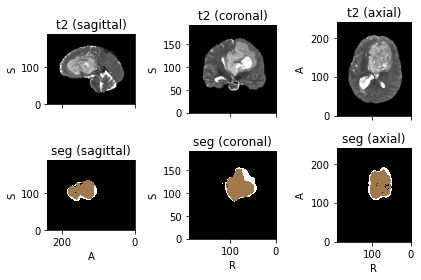

In [10]:
# dir = "/home/ludauter/Documents/brats_example/data/train"

# utils.plot_example(dataset,index=8,name = "exmple_large.png")

In [ ]:
dataset = tio.datasets.ixi.IXI(root = "/home/ludauter/Documents/IXI",download=True,modalities  = ["T1"],transform=preprocessing_transform)

dataset = tio.datasets.ixi.IXI(root = "/home/ludauter/Documents/IXI",download=True,modalities  = ["T1"],transform=preprocessing_transform)